In [101]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F 
from pyspark.sql import Window
import seaborn as sns
import plotly.express as px

In [102]:
filepaths = "../data/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv"
spark = SparkSession.builder.appName("anomaly").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
spark.sparkContext.version

'3.5.0'

## Count Nulls

In [103]:
df = spark.read.parquet("../data/cleaned/cleaned.pq")

In [104]:
columns = df.columns

In [90]:
df.agg(*[F.countDistinct(F.col(c)).alias(c) for c in columns]).show()

+-------+-------+---------+-----------+--------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+-----+--------------+-----+---+----+------+------+
|     ts|    uid|source_ip|source_port|destination_ip|destination_port|proto|service|duration|orig_bytes|resp_bytes|conn_state|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|label|detailed-label|   dt|day|hour|minute|second|
+-------+-------+---------+-----------+--------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+-----+--------------+-----+---+----+------+------+
|3394338|3394338|     2150|      21064|       1685416|             161|    3|      3|   40228|        47|        71|        10|     53|       48|          154|       39|          130|    4|             2|33620|  2|  11|   587| 33620|
+-------+-------+---------+-----------+--------------+----------

In [91]:
column_and_types = df.dtypes
not_timestamp = []

for a,b in column_and_types:
    if b != 'timestamp':
        not_timestamp.append(a)

In [38]:
columns

['ts',
 'uid',
 'source_ip',
 'source_port',
 'destination_ip',
 'destination_port',
 'proto',
 'service',
 'duration',
 'orig_bytes',
 'resp_bytes',
 'conn_state',
 'history',
 'orig_pkts',
 'orig_ip_bytes',
 'resp_pkts',
 'resp_ip_bytes',
 'label',
 'detailed-label',
 'dt',
 'day',
 'hour',
 'minute',
 'second']

In [92]:
not_timestamp

['ts',
 'uid',
 'source_ip',
 'source_port',
 'destination_ip',
 'destination_port',
 'proto',
 'service',
 'duration',
 'orig_bytes',
 'resp_bytes',
 'conn_state',
 'history',
 'orig_pkts',
 'orig_ip_bytes',
 'resp_pkts',
 'resp_ip_bytes',
 'label',
 'detailed-label']

In [39]:
temp = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in not_timestamp])

temp.show()

+---+---+---------+-----------+--------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+-----+--------------+
| ts|uid|source_ip|source_port|destination_ip|destination_port|proto|service|duration|orig_bytes|resp_bytes|conn_state|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|label|detailed-label|
+---+---+---------+-----------+--------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+-----+--------------+
|  0|  0|        0|          0|             0|               0|    0|      0|       0|         0|         0|         0|   2188|        0|            0|        0|            0|    0|       3392605|
+---+---+---------+-----------+--------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+-----+--------------+



## Common IPs

In [105]:
source_ips = df.select(F.col("source_ip")).distinct()
destination_ips = df.select(F.col("destination_ip")).distinct()
common_ips = source_ips.join(F.broadcast(destination_ips), source_ips.source_ip == destination_ips.destination_ip)

print("Source IPs:", source_ips.count())
print("Destination IPs:", destination_ips.count())
print("Common IPs:", common_ips.count())

Source IPs: 2150


Destination IPs: 1685416


Common IPs: 797


In [74]:
df.where((F.col("label") == "Benign")).count()

3734

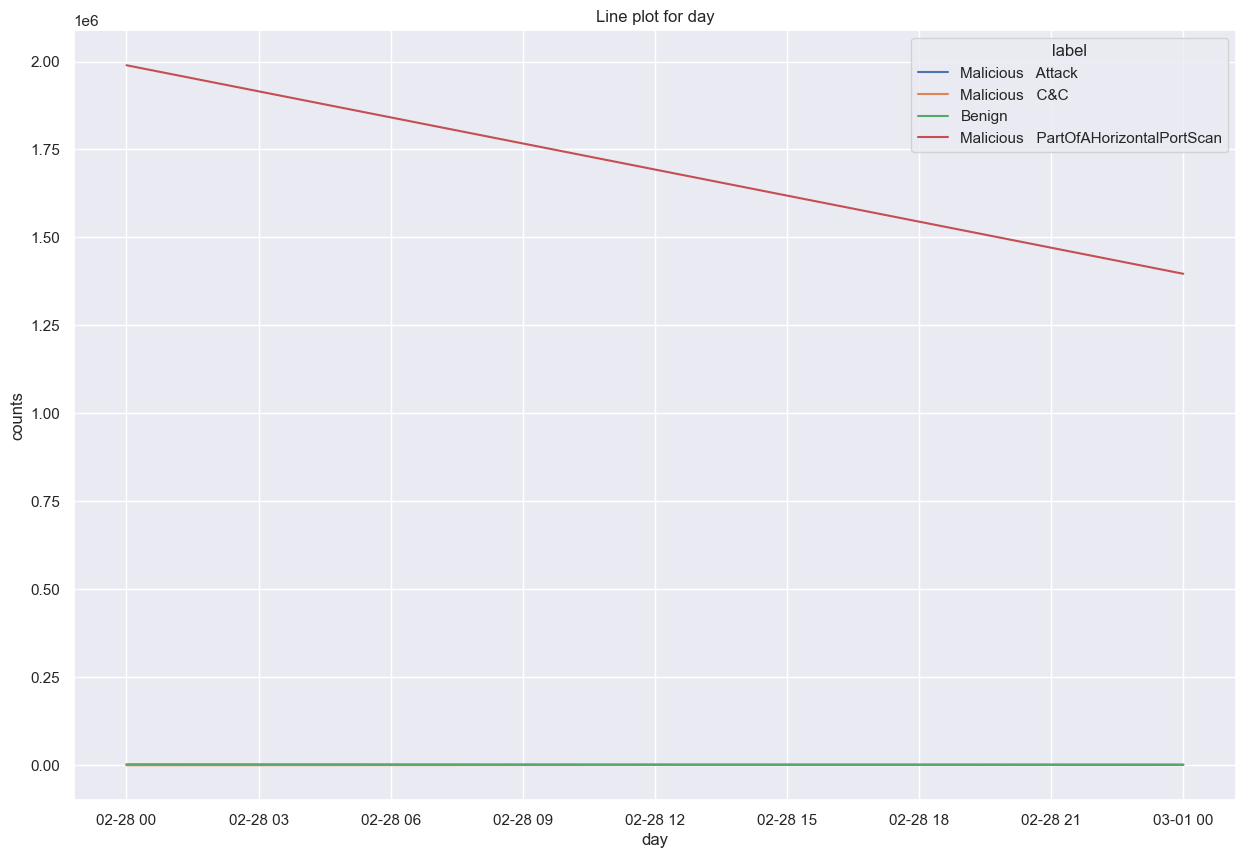

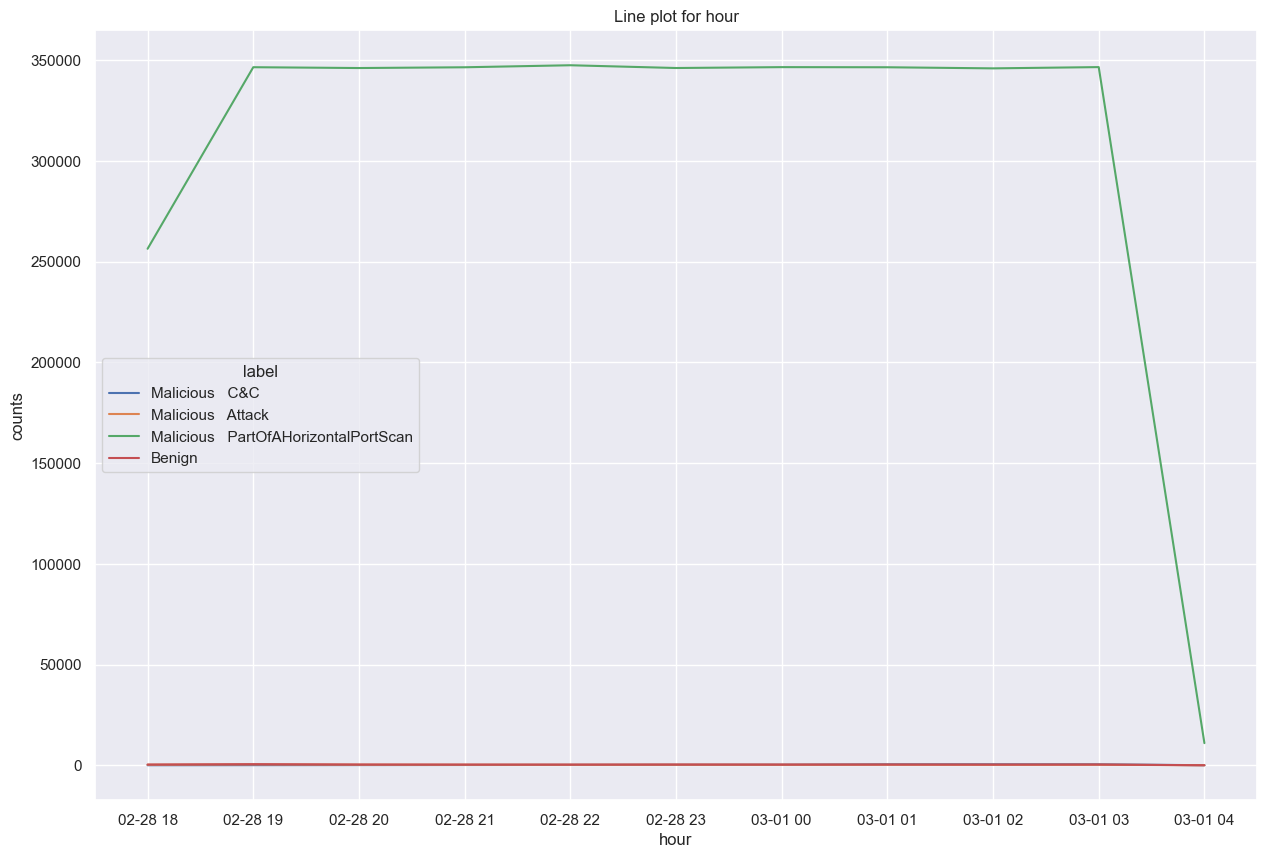

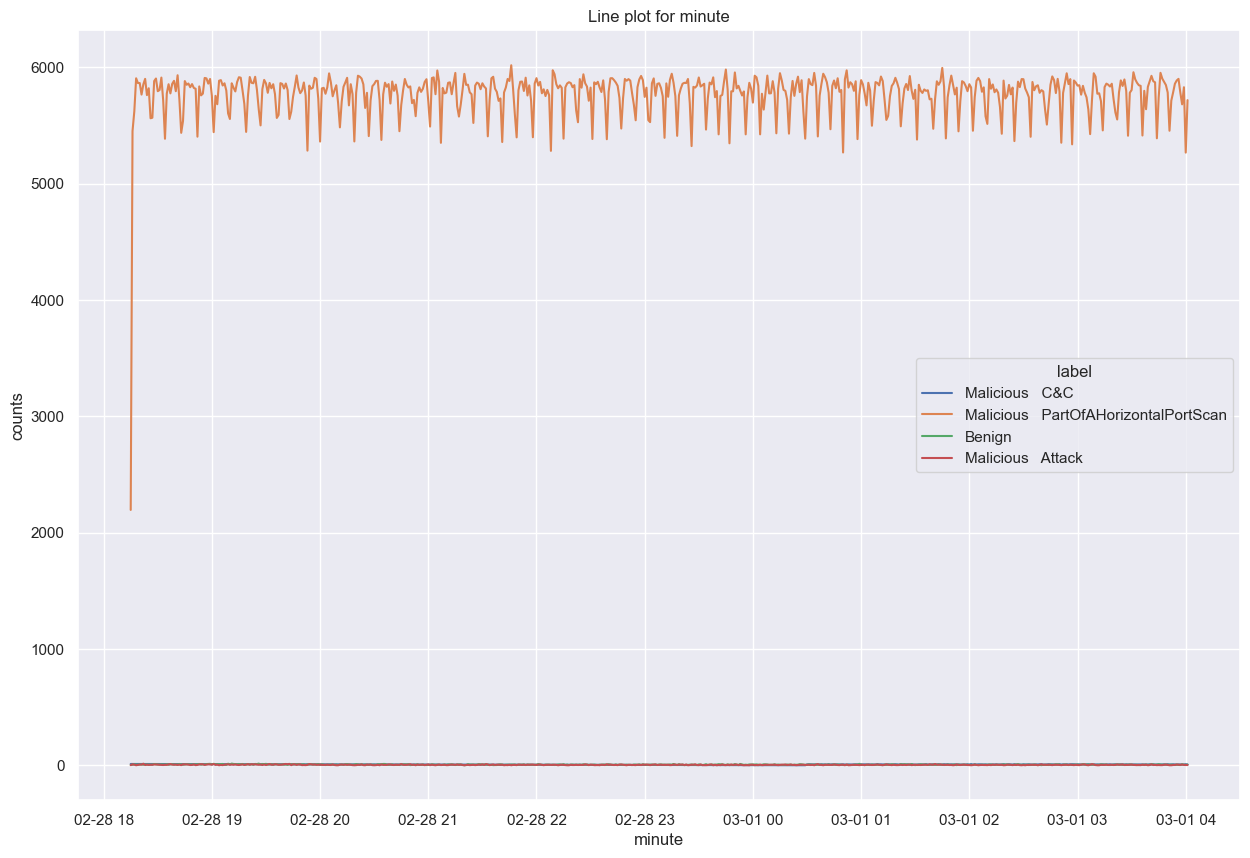

In [7]:
import matplotlib.pyplot as plt
sns.set_theme("notebook")

for agg in ['day', 'hour', 'minute']:

    plotting_table = df.groupBy([agg, "label"]).agg(F.count("uid").alias("counts")).orderBy(agg).toPandas()
    fig,ax = plt.subplots(1,1, figsize = [15,10])
    
    sns.lineplot(data = plotting_table, x=agg, y="counts", hue="label", markers=True, dashes=True, ax=ax)
    plt.title(f"Line plot for {agg}")
    
    plt.show()

+-----+-------+-------+
|proto|  count|percent|
+-----+-------+-------+
|  tcp|3390770| 0.9989|
| icmp|   2188| 6.0E-4|
|  udp|   1380| 4.0E-4|
+-----+-------+-------+

+-------+-------+-------+
|service|  count|percent|
+-------+-------+-------+
|missing|3394325|    1.0|
|   http|     11|    0.0|
|    dns|      2|    0.0|
+-------+-------+-------+

+----------+-------+-------+
|conn_state|  count|percent|
+----------+-------+-------+
|        S0|3387179| 0.9979|
|       REJ|   3343|  0.001|
|       OTH|   2188| 6.0E-4|
|        SF|   1249| 4.0E-4|
|    RSTOS0|    153|    0.0|
|      RSTO|     91|    0.0|
|      RSTR|     66|    0.0|
|        S2|     25|    0.0|
|        S1|     25|    0.0|
|        SH|     19|    0.0|
+----------+-------+-------+

+----------+-------+-------+
|   history|  count|percent|
+----------+-------+-------+
|         S|3387007| 0.9978|
|        Sr|   3343|  0.001|
|      NULL|   2188| 6.0E-4|
|        Dd|   1208| 4.0E-4|
|         D|    172| 1.0E-4|
|        

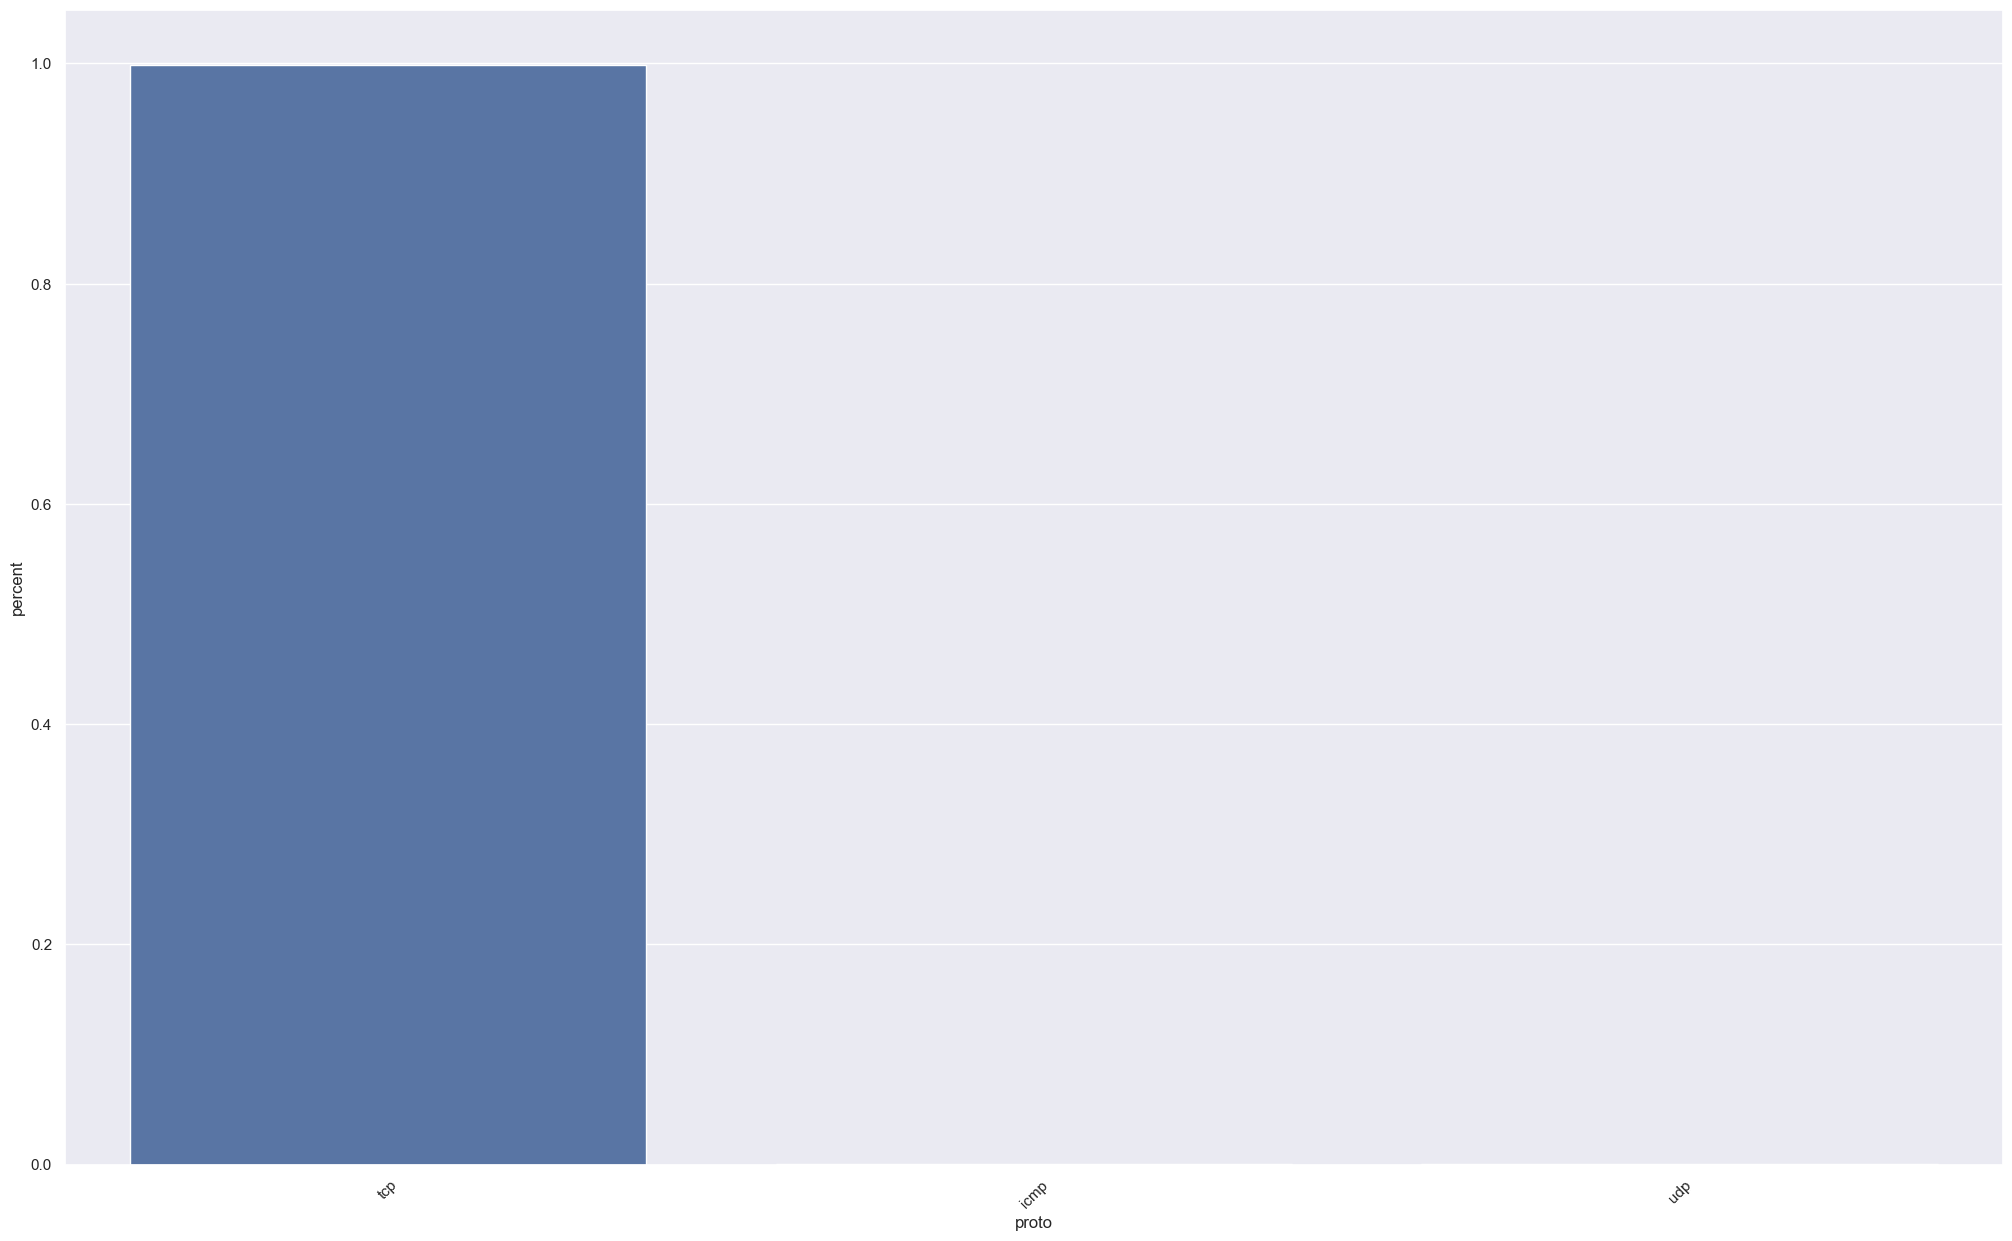

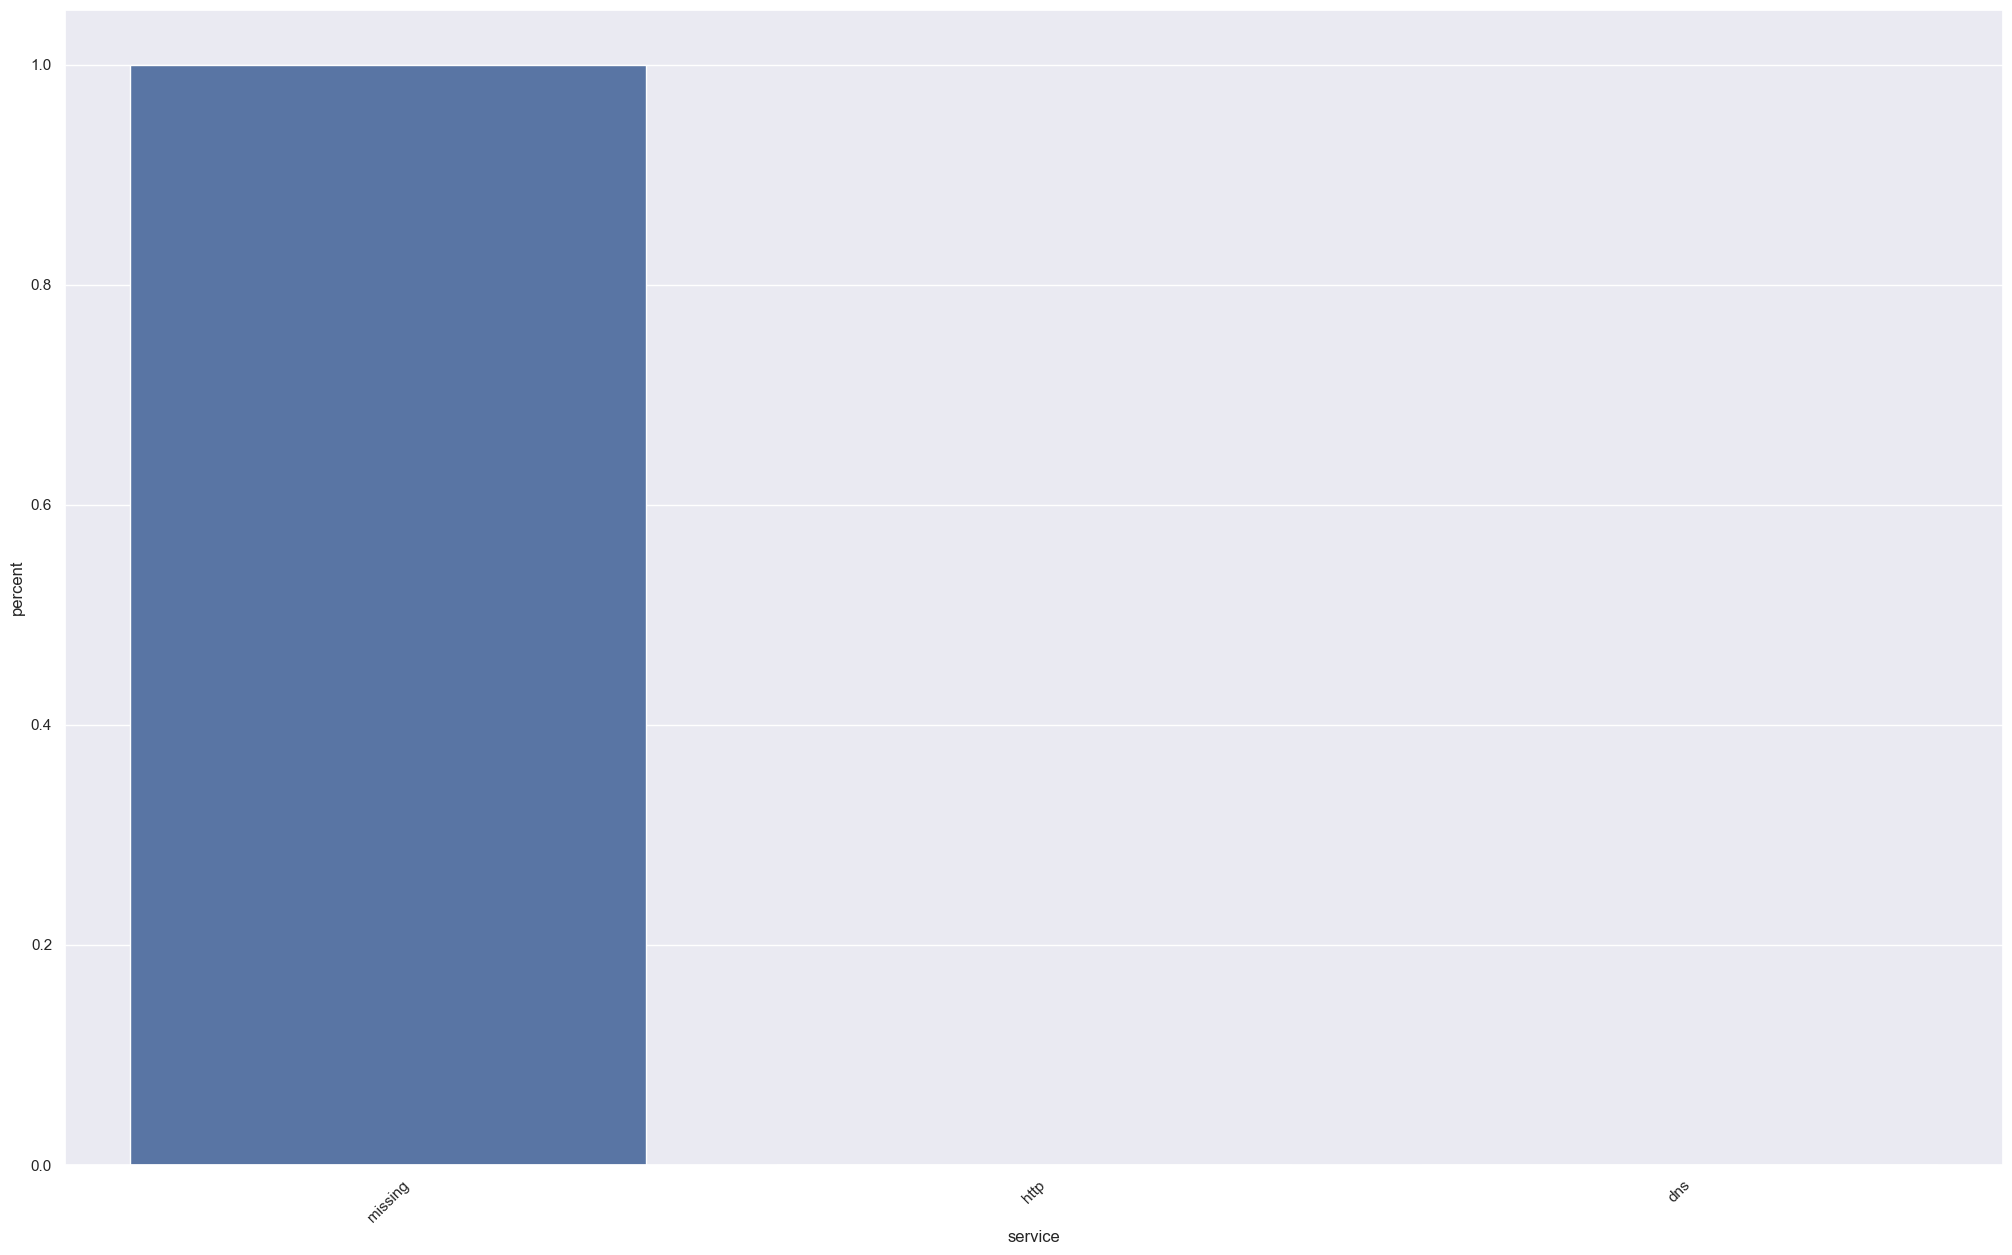

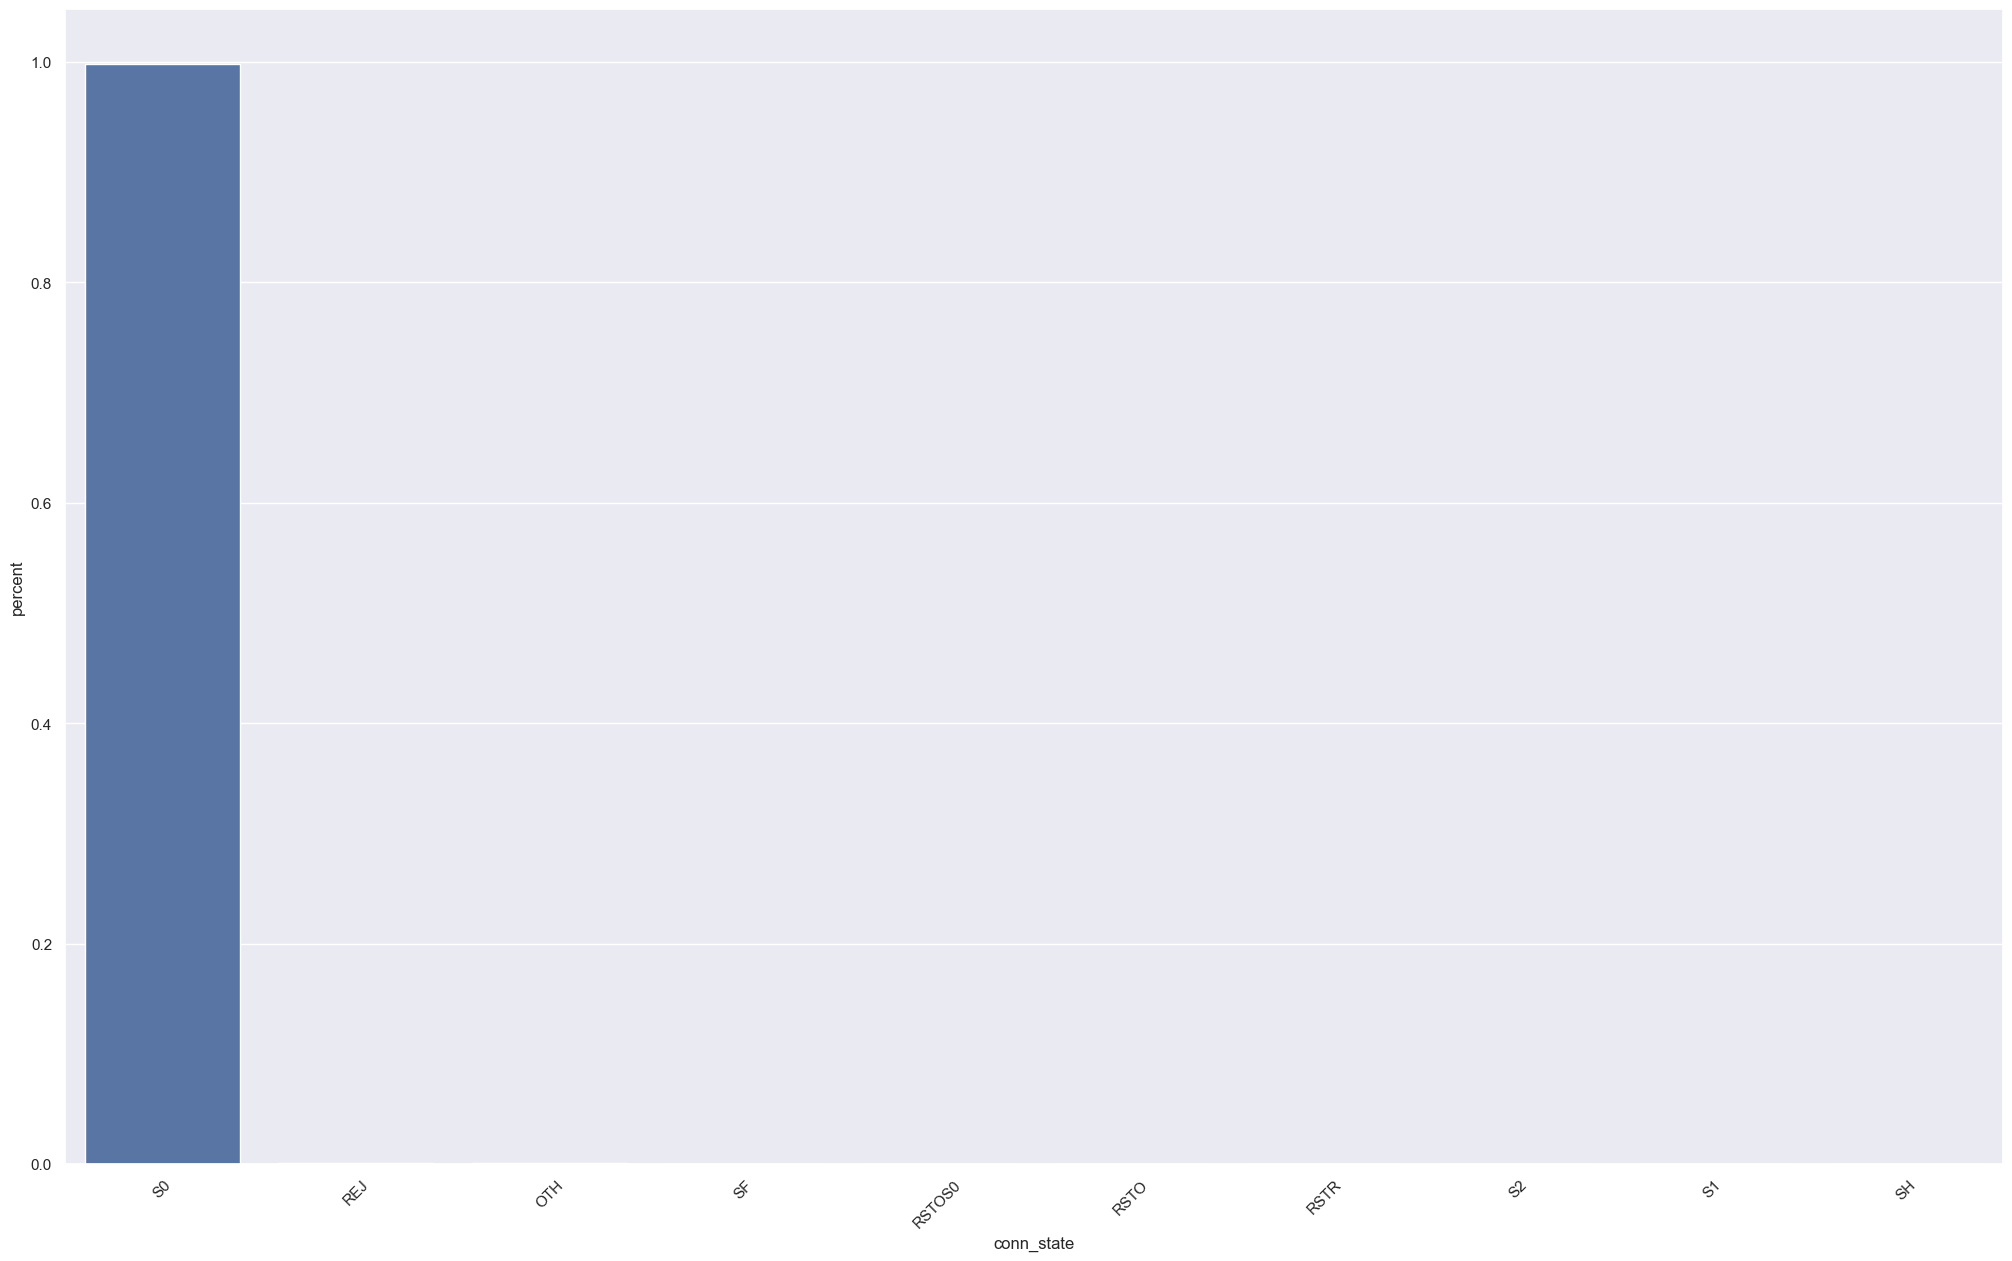

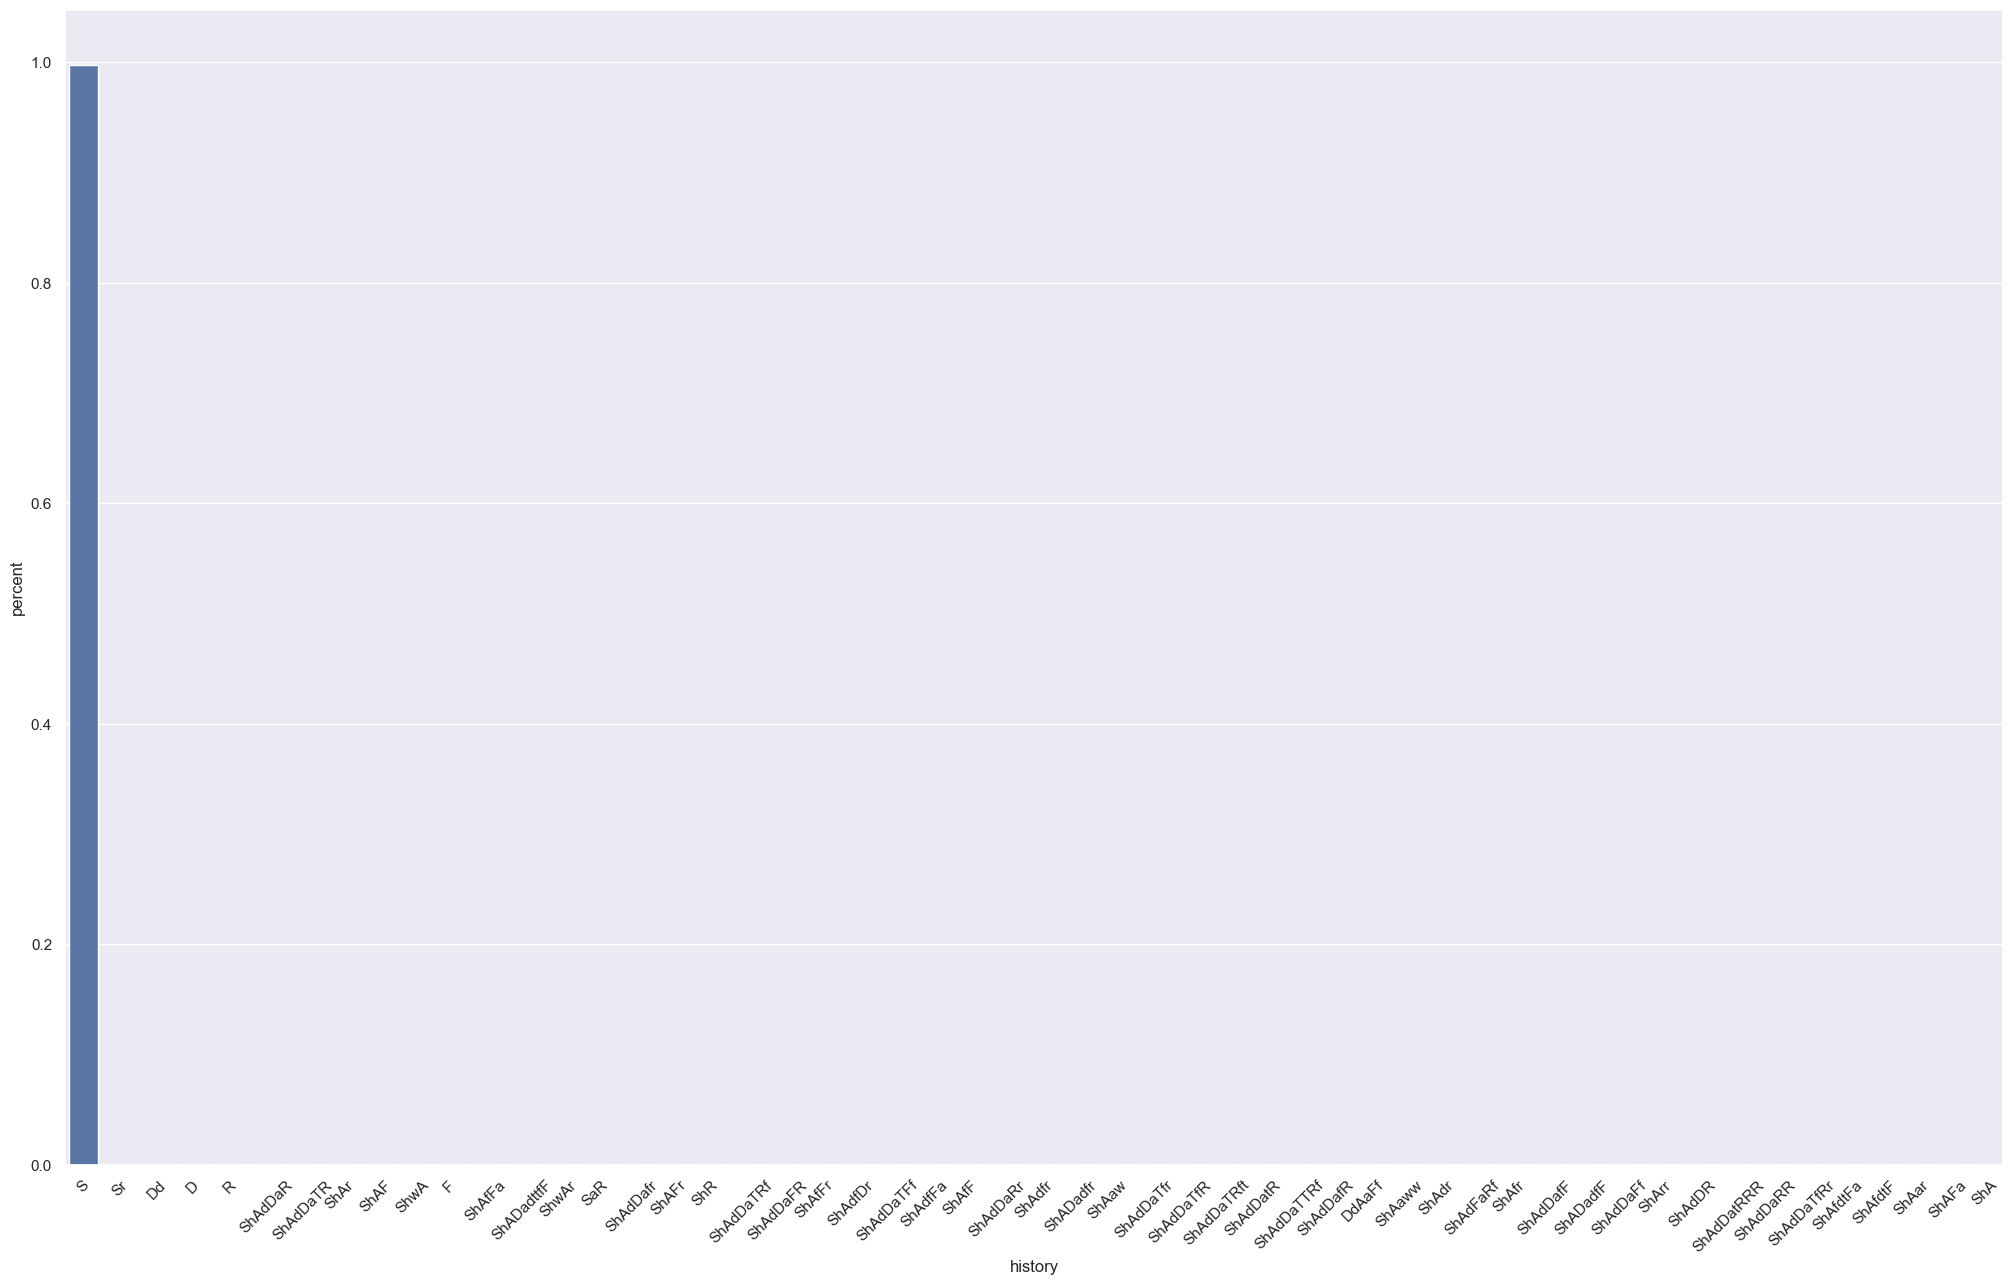

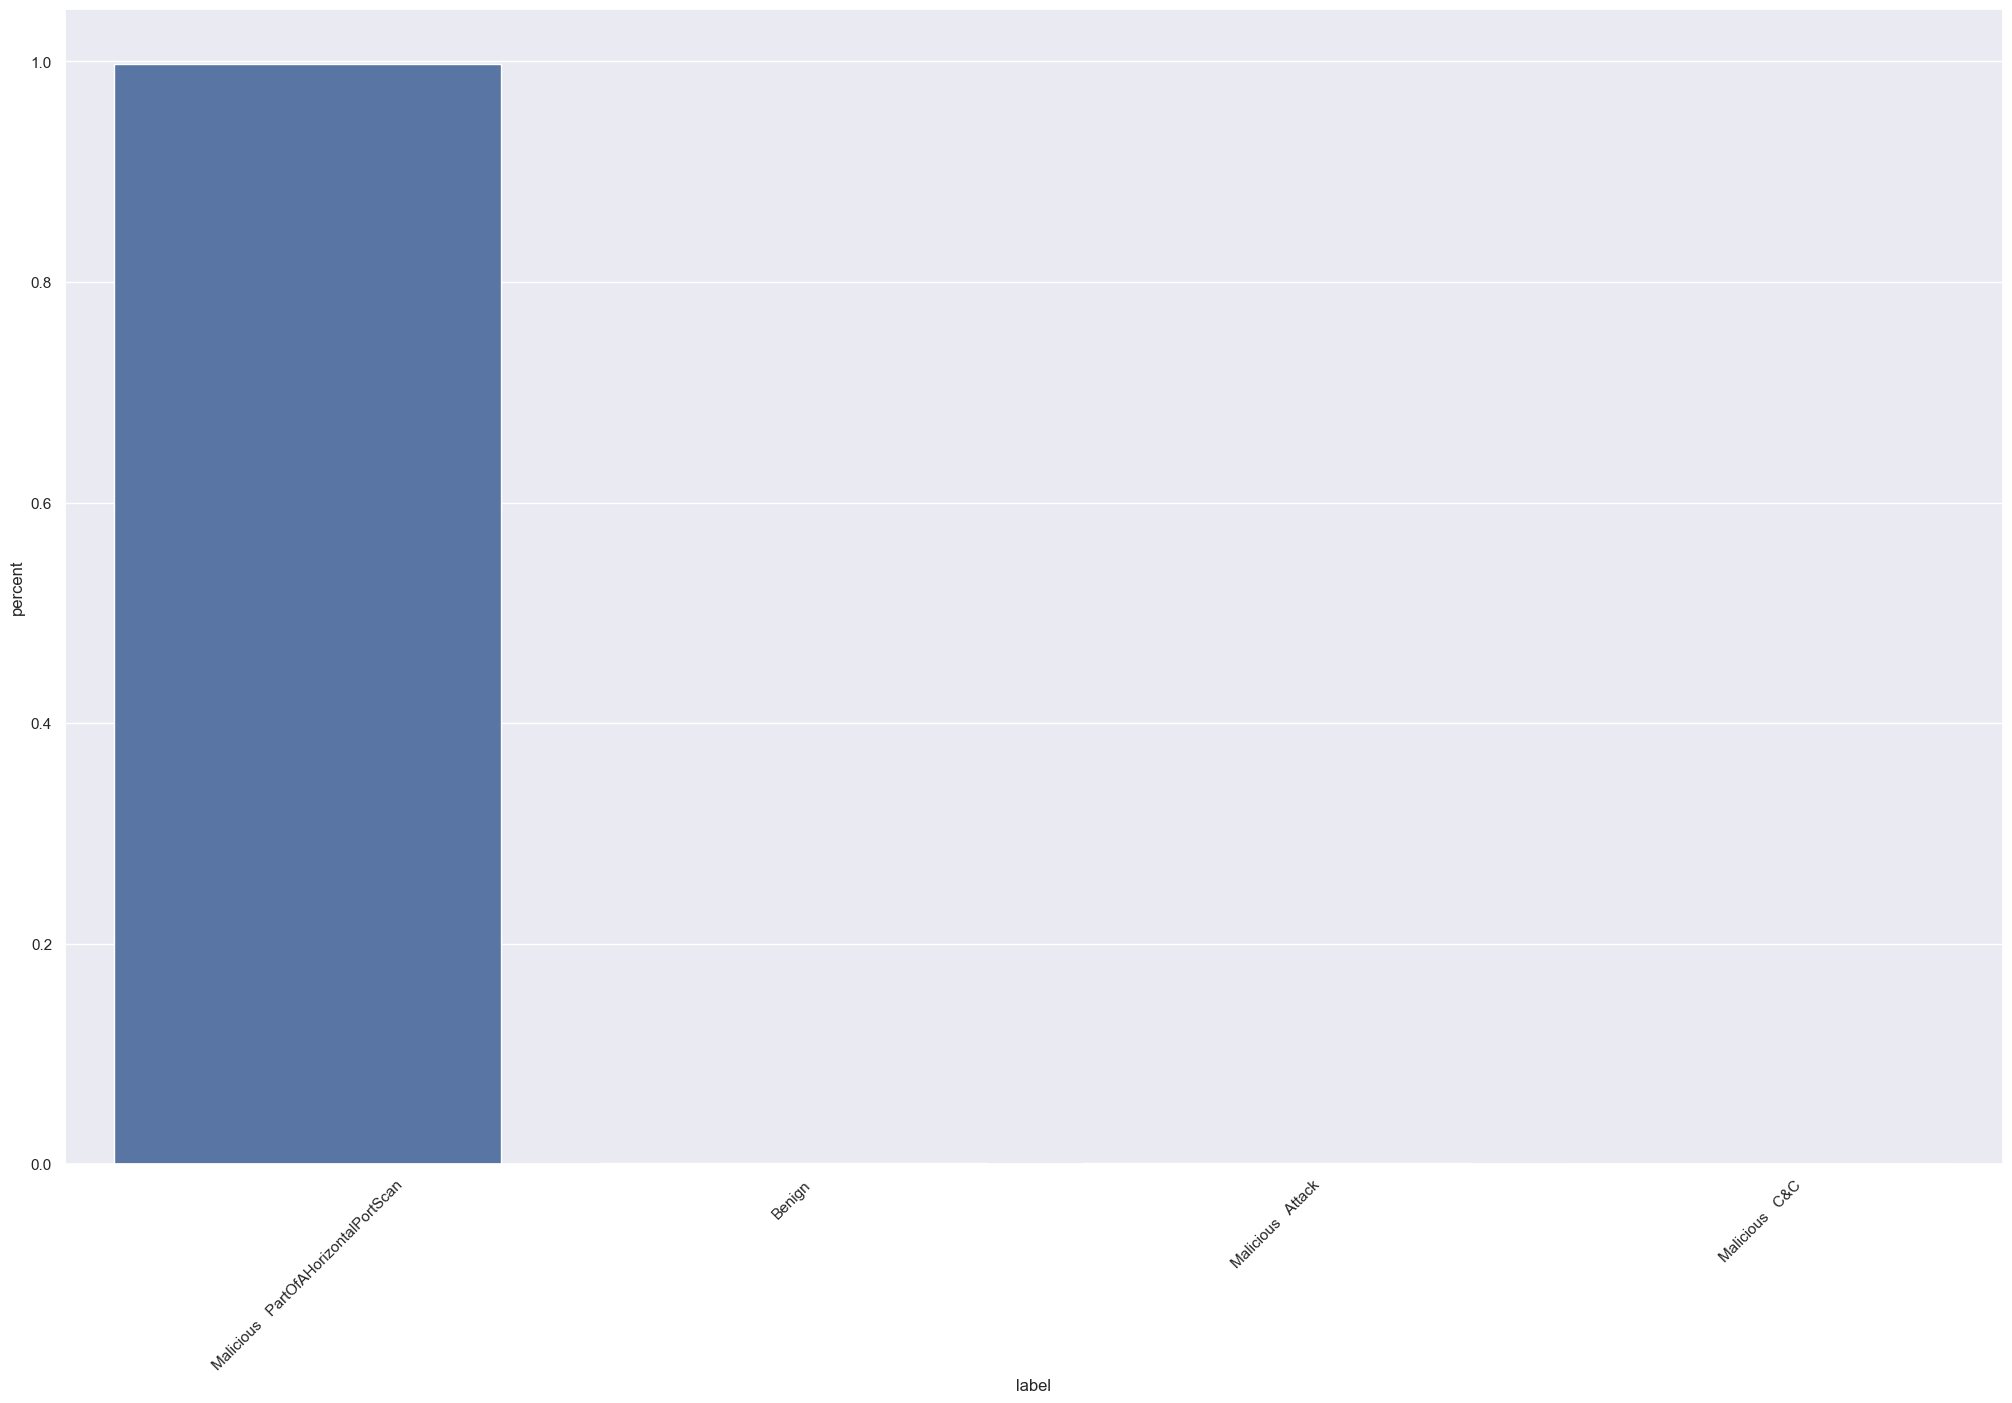

In [28]:
def counts(df, var):
    var_counts = df.groupBy(var).count().orderBy("count", ascending = False)
    
    var_counts = var_counts.withColumn("percent", F.round(F.col("count") / F.sum(F.col("count")).over(Window.partitionBy()), 4))
    var_counts.show()
    
    #fig, ax = plt.subplots(1,1, figsize = [10,12])
    fig, wide_ax = plt.subplots(1,1, figsize = [25, 15])
    #plt.title(f"Plot for {var} column")

    var_counts = var_counts.toPandas()
    sns.barplot(data = var_counts, x = var, y = "percent", ax=wide_ax)
    plt.xticks(rotation=45)
   
categorical_columns = ["proto", "service", "conn_state", "history", "label"]

for col in categorical_columns:
    counts(df, col)

In [29]:
df.show()

+-----------------+------------------+-------------+-----------+---------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+--------------------+--------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|               ts|               uid|    source_ip|source_port| destination_ip|destination_port|proto|service|duration|orig_bytes|resp_bytes|conn_state|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|               label|detailed-label|                 dt|                day|               hour|             minute|             second|
+-----------------+------------------+-------------+-----------+---------------+----------------+-----+-------+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+--------------------+--------------+-------------------+-------------------+-------------------+---

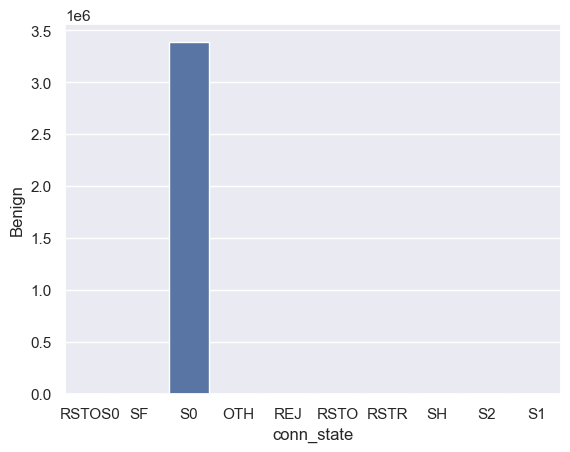

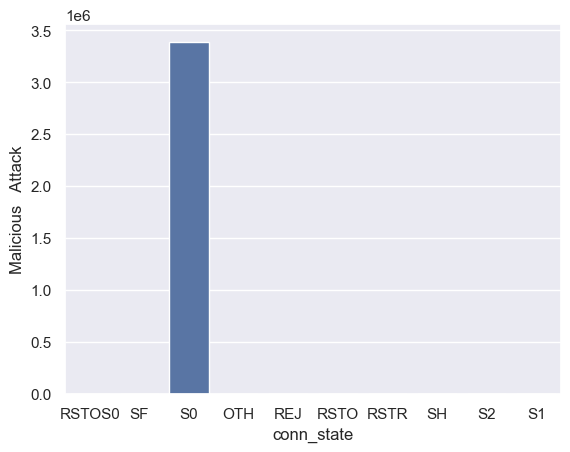

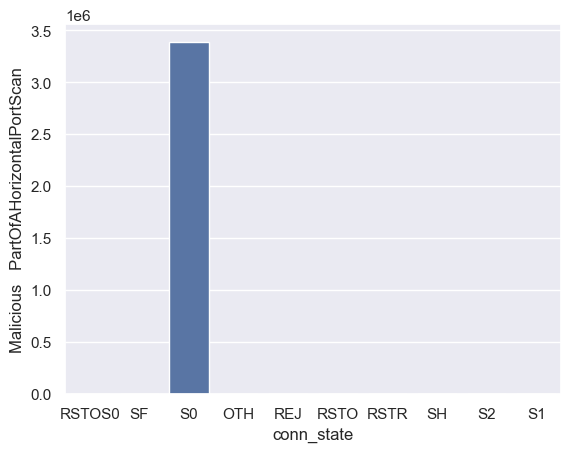

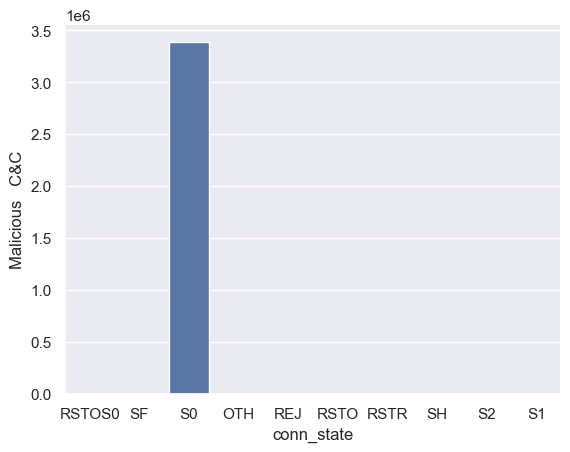

24/02/03 16:49:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [108]:
#Checks distribution of label across connection states
labels = df.select(F.col('label')).distinct().toPandas()
labels = list(labels['label'])

for label in labels:

    temp_df = df.groupBy(F.col('conn_state')).agg(F.count(F.col('label') == label).alias(label)).toPandas()
    #temp_df = temp_df.withColumn("percent", F.round(F.col("count") / F.sum(F.col("count")).over(Window.partitionBy()), 4))

    sns.barplot(temp_df, x = 'conn_state', y = label)
    plt.show()

In [ ]:


df.agg(
    F.min("dt").alias("min_date"),
    F.max("dt").alias("max_date")    
).show()